In [1]:
from IPython.core.display import display,HTML, Image, SVG
display(HTML("""<style>
    .container {width:96% !important;} 
    .prompt {min-width: 8ex; font-size: smaller; font-family: sans-serif;}
</style>"""))

In [2]:
import fnmatch
import glob
import json
import logging
import matplotlib
import os
import re
import sys
import traitlets

sys.path.insert(0,'/srv/home/nmew/myprojects/neural-nets/')
from collections import defaultdict, OrderedDict, Counter
import common.util as ut
from itertools import izip
import lasagne_nn.log_parser as lp
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import seaborn as sns

# setups
logging.getLogger().setLevel(logging.DEBUG)
reload(lp)
matplotlib.rcParams['savefig.dpi'] = 300
context = 'paper'

    
##### misc functions #####
class  Experiment(dict):
    def __init__(self, name):
        self.name = name
        self.folds = []
        self.converged_epochs = []
        self.trained_paths = []
      
    def __repr__(self):
        return str(vars(self))
    
    def __str__(self):
        return json.dumps(vars(self), indent=2)
        
    def set_converged_epoch(self, epoch, train_path, fold=None):        
        self.folds.append(fold)
        self.converged_epochs.append(epoch)
        self.trained_paths.append(train_path)

        
def long_substr(data):
    """
    Joins filename
    
    Params
    ========
    data : str
        where to find experiment results and logs

    Returns
    ========
    substr : str
        joined data
    """
    substr = ''
    if len(data) > 1 and len(data[0]) > 0:
        for i in range(len(data[0])):
            for j in range(len(data[0])-i+1):
                if j > len(substr) and all(data[0][i:i+j] in x for x in data):
                    substr = data[0][i:i+j]
    return substr


def get_expts(expt_json):
    """
    Given a filename for a pnr experiment that contains converged epochs, 
    
    Parameters
    ----------
    expt_json : str
        *.json containing experiment converged epochs, folds, and paths

    Returns
    -------
    expt_epochs_json : list of Experiment
        list of class Experiment containing names, trained_paths, folds, and converged epochs for an experiment

    """
    converged_epochs = (expt_json)
    with open(converged_epochs, "r") as fp:
        expts = json.load(fp)
    experiments = []
    for e in expts:
        tmp = Experiment(e["name"])
        for epoch, path, fold in izip(e["converged_epochs"], e["trained_paths"], e["folds"]):
            tmp.set_converged_epoch(epoch, path, fold)
        experiments.append(tmp)
        del(tmp)    
    return experiments


##### Filesystem handler functions #####

def get_env_var(handle):
    """Get an environment variable given the handle for the bash variable
    
    Params
    ========
    handle : str
        handle for a bash variable
        
    Returns
    ========
    tmp : str
        environment variable as a string
    """ 
    tmp = os.getenv(handle)
    if not tmp:
        raise LookupError("Environment variable: {} not set.".format(handle))
    return tmp.strip("'")



def find(pattern, path, dironly=False):
    """
    find by regex pattern in path
    
    Params
    ========
    pattern : str
        regex to find
    path : str
        path to search for regex
        
    Kwargs
    ========
    dironly : bool
        whether to report the file (False) or directory (True) when pattern found (Default: False)
        
    Returns
    ========
    result : list of str
        list of files or dirs containing pattern
    """
    result = []
    for root, dirs, files in os.walk(os.path.abspath(path)):
        for name in files:
            if fnmatch.fnmatch(name, pattern):
                if dironly:
                    result.append(root)
                    break
                else:
                    result.append(os.path.join(root, name))
    return result


##### Data reader functions #####

def get_log_and_result_files(basepath, pattern_logs='*.log', pattern_results='results.csv', 
                             ignore_result_files_in_train_dir=False):
    """
    Get trained network logs and result files, optionally ignoring old result files found in the train directory
    
    Params
    ========
    basepath : str
        where to find experiment results and logs
        
    Kwargs
    ========
    pattern_logs : str
        pattern logs of interest (Default: *.log)
    pattern_results : str
        what the results are saved as in basepath (Default: results.csv)
    ignore_result_files_in_train_dir : bool
        whether to ignore results in the train directory (True) or not (False) (Default: False)
        
    Returns
    ========
    resultfiles : set
        list of result files or dirs
    
    """
    logfile_dirs = find(pattern_logs, basepath, dironly=True)
    resultfiles = {}
    for logfiledir in logfile_dirs:
        lf, af = ut.get_logfile_and_argfile_from_dir(logfiledir)
        if lf:
            result_files = find(pattern_results, logfiledir)            
            if ignore_result_files_in_train_dir:
                result_files = [rfile for rfile in result_files 
                                if os.path.dirname(rfile) != logfiledir]
            resultfiles[lf] = result_files
            
    return resultfiles


def get_network_results_in_base_path(basepath, ignore_base_paths=None, ignore_result_files_in_train_dir=False):
    """
    Get pandas dataframe of results and metadata of all trained networks found under a path in the filesystem
    
    Params
    ========
    basepath : str
        where to find experiment results and logs
        
    Kwargs
    ========
    ignore_base_paths : list
        Paths to ignore (Default: None)
    ignore_result_files_in_train_dir : bool
        Whether to ignore files found in the parent train dir (True) or not (False) (Default: False)
        
    Returns
    ========
    results_df : pd.DataFrame
        summarized dataframe with metrics of interest
    inds : list
        list of indices/descriptors of datasets
    metrics : list
        list of metrics kept
    """
    log_and_results = get_log_and_result_files(
        basepath, ignore_result_files_in_train_dir=ignore_result_files_in_train_dir)    
    
    # filter out paths to ignore
    train_logs, result_csvs = [], []
    ignore_base_paths = [os.path.abspath(p) + os.path.sep for p in ignore_base_paths] if ignore_base_paths else []
    for log, results in log_and_results.items():
        if not ignore_base_paths or not any(map(os.path.abspath(log).startswith, ignore_base_paths)):
            # todo: refactor get_multiple_network_results to accept dict
            train_logs += [os.path.dirname(log)] * len(results)
            result_csvs += results

    results_df, ordered_cols, metric_names = lp.get_multiple_network_results(result_csvs, train_logs)
    # TODO: move summarize to lp.get_multiple_network_results ?
    
    results_df, inds, metrics = summarize_and_order_network_result_df_cols(results_df, metric_names)
    return results_df, inds, metrics


##### Dataframe consolidation functions #####

def get_assigned_epochs(df, expt_epochs_json):
    """
    Iterates through a list of converged epochs and pulls that data from a df of experiments
    
    Parameters
    ----------
    df : pd.DataFrame
        pandas dataframe containing experiment metrics and info
    expt_epochs_json : list of dicts
        list of dicts containing: trained_paths, folds, and converged epochs for an experiment

    Returns
    -------
    metric_df : pd.DataFrame
        dataframe containing all metrics at a converged epoch
    """
    first = True
    for pnr_expt_ratio in expt_epochs_json:
        for k in np.arange(0, len(pnr_expt_ratio.trained_paths), 1):
            tmp_dir = pnr_expt_ratio.trained_paths[k]
            tmp_epoch = pnr_expt_ratio.converged_epochs[k]
            # remove trailing / from tmp_dir...
            matching_dir = df.train_directory == tmp_dir[0:-1]
            matching_epoch = df.epoch == tmp_epoch
            tmp_df = df[matching_dir & matching_epoch] 
            if first: 
                m_df = tmp_df
                first = False
            else: 
                m_df = pd.concat([m_df, tmp_df])
    return m_df


def summarize_stochastic_negative_columns(dataframe, remove_boolean_cols=True):
    """
    Replaces categorical descriptors in data with actual names. 
    Uses 'sneg_type' column and replaces categorical values 0,1,2 with 'No Stochastic Negatives', 'Stochastic Negatives',
    'SEA Stochastic Negatives', respectively into 'Negative Training Description' column.
    By default, remove the boolean columns: 'stochastic_negatives', 'sea_stochastic_negs'
    
    Params
    ========
    dataframe : pd.DataFrame
        dataframe to modify
        
    Kwargs
    ========
    remove_boolean_cols : bool
        remove columns 'stochastic_negatives', 'sea_stochastic_negs' (Default: True)
        
    Returns
    ========
    dataframe : pd.DataFrame
        input dataframe with 'Negative Training Description' and 'sneg_type' added instead of categorical descriptors
    """
    stochastic_negative_columns = ['stochastic_negatives', 'sea_stochastic_negs']
    if dataframe is not None and all([col in dataframe.columns for col in stochastic_negative_columns]):
        new_df = pd.Series(
            dataframe[stochastic_negative_columns].sum(axis=1), 
            index=dataframe.index)
        dataframe['sneg_type'] = new_df
        new_df = new_df.replace(2, 'SEA Stochastic Negatives')
        new_df = new_df.replace(1, 'Stochastic Negatives')
        new_df = new_df.replace(0, 'No Stochastic Negatives')
        dataframe['Negative Training Description'] = new_df
        if remove_boolean_cols:
            dataframe.drop(stochastic_negative_columns, axis=1, inplace=True) 

    
def summarize_and_order_network_result_df_cols(dataframe, metric_names, columns_to_ignore=None):
    """
    Clean up netowork results for csvs by removing uneccessary columns
    
    Params
    ========
    dataframe : pd.DataFrame
        dataframe to modify
    metric_names : list of str
        list of metric names to summarize
        
    Kwargs
    ========
    columns_to_ignore : list of str
        remove columns from dataframe if you'd like to ignore them (Default: None)
        
    Returns
    ========
    dataframe : pd.DataFrame
        input dataframe with metrics of interest
    indices : list
        list of indices/descriptors of datasets
    ordered_metrics_to_keep : list
        list of metrics kept
    """
    summarize_stochastic_negative_columns(dataframe)
    columns_to_ignore = columns_to_ignore if columns_to_ignore else []
    
    # ignore crap metrics
    default_metrics_to_ignore = ['epoch', 'labeled-f2.0--Negative--_drug-matrix', 'binary-auc-t5.0_drug-matrix', 'binary-auc-t6.0_drug-matrix', 'r2_timesplit_validation', 'r2']
    more_metrics_to_ignore = [c for c in metric_names if c.endswith('_result_file') or ('----micro' in c) or ('----macro' in c)]
    metrics_to_ignore = default_metrics_to_ignore + columns_to_ignore + more_metrics_to_ignore
    
    # order important metrics first
    ordered_metrics = ['r2_test', 'r2_train', 'r2_drug-matrix', 'r2_drug-matrix-known-values', 'r2_timesplit-validation']
    first_metrics_to_keep = [c for c in dataframe.columns if c in ordered_metrics]
    last_metrics_to_keep = [c for c in metric_names if c not in first_metrics_to_keep + metrics_to_ignore]
    ordered_metrics_to_keep = first_metrics_to_keep + last_metrics_to_keep
    
    # define indices
    indices_to_ignore = ['average_epoch_duration'] + columns_to_ignore
    indices = [c for c in dataframe.columns if (c not in list(metric_names) + indices_to_ignore)] + ['epoch']
    
    return dataframe[indices + ordered_metrics_to_keep], indices, ordered_metrics_to_keep


##### Plotting functions #####

def set_nice_spines(ax=None, sides=('left', 'bottom'), color="black", linewidth=1.5):
    """
    Nice spine formatting for plots
    """
    if not ax:
        ax = plt.gca()
    for side in sides:
        ax.spines[side].set_visible(True)
        ax.spines[side].set_color(color)
        ax.spines[side].set_linewidth(linewidth)
        

def plot_metrics_by_pnr(resdf, metrics, expt_epochs_json, palette=None, metric_names=None, label_suffix='', linestyle='-', hatch=''):  
    """
    Plots a positive-negative ratio experiment given a dataframe of experiments, metrics of interest, and a list of converged epochs
    
    Parameters
    ----------
    df : pd.DataFrame
        pandas dataframe containing experiment metrics and info
    metric : str
        metric of interest (e.g. r2_train)
    expt_epochs_json : list of dicts
        list of dicts containing: trained_paths, folds, and converged epochs for an experiment
        
    Kwargs
    -------
    metric_names : list
        list of names for provided metrics
    label_suffix : str
        Name to add to end of legend names (Default '')
    linestyle : str
        matplotlib plotting variable for linestyle (Default '-')
    hatch : str
        What hatch to use for matplotlib filling of fold variance (Default '')
    """
    if metric_names is None:
        metric_names = list(metrics)
    if not palette:
        palette = sns.color_palette("husl", len(metrics))
    
    #sns.set_palette(palette)
    sns.set_style("whitegrid")
    for i, (metric, metric_name) in enumerate(zip(metrics, metric_names)):
        metric_df = get_sneg_pnrs(resdf, metric, expt_epochs_json)
        metric_df = metric_df.sort_values('enforced_neg_percent')
        metric_df = metric_df[['enforced_neg_percent', metric]]
        
        mean_df = metric_df.groupby('enforced_neg_percent', as_index=False).mean()        
        max_err = metric_df.groupby('enforced_neg_percent', as_index=False).max()
        min_err = metric_df.groupby('enforced_neg_percent', as_index=False).min()
        
        plt.plot(mean_df['enforced_neg_percent'], mean_df[metric], label=metric_name+label_suffix, linestyle=linestyle, color=palette[i])
        plt.fill_between(mean_df['enforced_neg_percent'], 
                         min_err[metric], max_err[metric], 
                         alpha=.25, color=palette[i], hatch=hatch)

def get_sneg_pnrs(resdf, metric, expt_epochs_json):
    """
    get sneg pnrs for plotting based on a pre-determined set of converged epochs
    
    Parameters
    ----------
    resdf : pd.DataFrame
        pandas dataframe containing experiment metrics and info
    metric : str
        metric of interest (e.g. r2_train)
    expt_epochs_json : list of dicts
        list of dicts containing: trained_paths, folds, and converged epochs for an experiment

    Returns
    -------
    metric_df : pd.DataFrame
        dataframe containing the metric of interest at a converged epoch along with some other reporting metrics
    """
    
    metric_df = get_assigned_epochs(resdf, expt_epochs_json)
    metric_df = metric_df.sort_values('positive_negative_ratio')
    metric_df = metric_df[['positive_negative_ratio','epoch', 'train_directory', metric]]
    metric_df['is_mean'] = False
    metric_df = metric_df.rename(index=str, columns={'Score':metric})
#     metric_df['positive_negative_ratio'] = np.asarray(metric_df['positive_negative_ratio'].values, dtype=np.int)
    metric_df['enforced_neg_percent'] = (100 / (1 + metric_df['positive_negative_ratio']))
    metric_df['ppos'] = 100 - (100 / (1 + metric_df['positive_negative_ratio']))
    metric_df.loc[metric_df['positive_negative_ratio'] == 0.0, 'enforced_neg_percent'] = 0.0
    metric_df.loc[metric_df['positive_negative_ratio'] == 0.0, 'ppos'] = 100.0
    metric_df = metric_df.sort_values('enforced_neg_percent')
    base_lcs = long_substr(metric_df['train_directory'].values.tolist())
    metric_df = metric_df.sort_values(['enforced_neg_percent', 'train_directory'])
    return metric_df


def plot_metric_by_dset(df, met_type, expt_json, cutoff=None, rm_unknowns=False):
    """
    Plots a positive-negative ratio experiment given a dataframe of experiments, metric, and a list of converged epochs
    
    Parameters
    ----------
    df : pd.DataFrame
        pandas dataframe containing experiment metrics and info
    met_type : str
        metric of interest (e.g. r2_train)
    expt_json : list of Experiments
        list of experiments with converged epochs
        
    Kwargs
    -------
    cutoff : float
        Value to report e.g. 6.0 for pAC50 of 6.0 reporting for drug matrix (Default: None)
    rm_unknowns: bool
        remove unknown primary screen info from plots (mostly for r2 analysis; Default: False)
    """
    
    # sneg_type       
    # no sea  = 1
    # sea = 2
    
    network_info = ["input_shape", "num_hidden_layers", "layer_shape", "output_activation_function", 
                "regularization_function", "regularization_lambda", "update_function", 
                "update_momentum","update_learning_rate", "negative_threshold", 
                "positive_negative_ratio", "training_data_filename", "multi_instance", 
                "training_script_filename", "training_cases", "machine_platform", "random_seed", 
                "total_trained_epochs", "trained_network_hash", "train_directory", "sneg_type", 
                "Negative Training Description", "epoch"]
    
    ignore_list = ["r2_timesplir2_timesplit-validation", "r2_timesplit-valir2_timesplit-validation", 
                   "r2_tr2_train", "r2_trainmatthews-corrcoef_binary-5.0_test", 
                   "r2_tramatthews-corrcoef_binary-5.0_test", "r2r2_test"]
    
    results_df = df[df['sneg_type'] != 2].copy()
#     results_df  = filter_for_complete_pnrs(results_df)
    
    metrics = [i for i in results_df.columns if i not in network_info]
    
    if rm_unknowns: 
        metrics = [i for i in metrics if i != 'r2_drug-matrix']
    
    if type(met_type) == str:
        filtered_metrics = [j for j in metrics if met_type in j and j not in ignore_list]
    else:
        filtered_metrics = [j for j in metrics if j in met_type and j not in ignore_list]
    
    if cutoff is not None:
        rm_cutoff = '5.0' if cutoff == 6.0 else '6.0'

        
    metrics = list(reversed([m for m in filtered_metrics if rm_cutoff not in m]))
    metric_names = [m
                     .replace('-known-values',' (Known Values)')
                     .replace('timesplit-validation','Time-Split')
                     .replace('test','Test-Set')
                     .replace('train','Train-Set')
                     .replace('drug-matrix-known-values', 'Drug-Matrix (Known Values)')
                     .replace('drug-matrix', 'Drug-Matrix')
                     .replace('binary-auc-t6.0-tpr-fpr', 'ROC AUC')
                     .replace('binary-auc-t6.0-precision-recall', 'PR AUC')
                     .replace('matthews-corrcoef_binary-6.0','Matthews CC')
                     .replace('labeled-f2.0--Positive--_binary-6.0','F2')
                     .replace('_',' ')
                     .replace('r2','$\\regular{R^2}$')
                     .replace("relgt-", "")
                    for m in metrics]

    sns.set_style("whitegrid")

    fig, ax = plt.subplots(figsize=(12,8))
    
    plot_metrics_by_pnr(results_df, metrics, expt_json, metric_names=metric_names)
    
    plt.ylim(ymin=0., ymax=1.)
    set_nice_spines(ax)

    minorLocator = matplotlib.ticker.AutoMinorLocator()
    ax.xaxis.set_minor_locator(minorLocator)

    ax.xaxis.grid(True, which='minor') 

In [14]:
home_save_dir = get_env_var("HOME_SAVE_BASE")
srv_save_dir = get_env_var("DATA_SAVE_BASE")
proj_dir = get_env_var("NMEW_PROJ_BASE")
loss_dir = "{}/output/20180815_Paper_Retrains/trained_nets".format(home_save_dir)

std_sma_dir = "{}/lr_nesterov_binary_classifier_1024_2048_3072/".format(loss_dir)
std_sma_basepath = os.path.join(std_sma_dir, "CLASSIFIER_SMA_RATIOS")

test_std_dir = "{}/lr_nesterov_binary_classifier_1024_2048_3072/".format(loss_dir)
test_std_basepath = os.path.join(std_sma_dir, "CLASSIFIER_STD_RATIOS")

In [15]:
preds_dir = "{}/output/20180815_Paper_Retrains/predictions".format(home_save_dir)

std_pnr_epochs = get_expts("{}/{}/experiments_edited.json".format(preds_dir, "CLASSIFIER_SMA_RATIOS"))

test_std_pnr_epochs = get_expts("{}/{}/experiments_edited.json".format(preds_dir, "CLASSIFIER_STD_RATIOS"))

In [16]:
std_pnr_results_df, std_pnr_inds, std_pnr_metrics = get_network_results_in_base_path(std_sma_basepath)

DEBUG:root:this_scripts_module_name: ipykernel_launcher
INFO:root:found logfile: /srv/home/ecaceres/data_save_folders/output/20180815_Paper_Retrains/trained_nets/lr_nesterov_binary_classifier_1024_2048_3072/CLASSIFIER_SMA_RATIOS/fold_1/pnr_9.0/lr_nesterov_binary_classifier_1024_2048_3072_INFO.log
INFO:root:found argfile: /srv/home/ecaceres/data_save_folders/output/20180815_Paper_Retrains/trained_nets/lr_nesterov_binary_classifier_1024_2048_3072/CLASSIFIER_SMA_RATIOS/fold_1/pnr_9.0/lr_nesterov_binary_classifier_1024_2048_3072_args.txt
DEBUG:root:this_scripts_module_name: ipykernel_launcher
DEBUG:root:this_scripts_module_name: ipykernel_launcher
INFO:root:found logfile: /srv/home/ecaceres/data_save_folders/output/20180815_Paper_Retrains/trained_nets/lr_nesterov_binary_classifier_1024_2048_3072/CLASSIFIER_SMA_RATIOS/fold_1/pnr_0.1111/lr_nesterov_binary_classifier_1024_2048_3072_INFO.log
INFO:root:found argfile: /srv/home/ecaceres/data_save_folders/output/20180815_Paper_Retrains/trained_ne

DEBUG:root:this_scripts_module_name: ipykernel_launcher
DEBUG:root:this_scripts_module_name: ipykernel_launcher
INFO:root:found logfile: /srv/home/ecaceres/data_save_folders/output/20180815_Paper_Retrains/trained_nets/lr_nesterov_binary_classifier_1024_2048_3072/CLASSIFIER_SMA_RATIOS/fold_2/pnr_0.1111/lr_nesterov_binary_classifier_1024_2048_3072_INFO.log
INFO:root:found argfile: /srv/home/ecaceres/data_save_folders/output/20180815_Paper_Retrains/trained_nets/lr_nesterov_binary_classifier_1024_2048_3072/CLASSIFIER_SMA_RATIOS/fold_2/pnr_0.1111/lr_nesterov_binary_classifier_1024_2048_3072_args.txt
DEBUG:root:this_scripts_module_name: ipykernel_launcher
DEBUG:root:this_scripts_module_name: ipykernel_launcher
INFO:root:found logfile: /srv/home/ecaceres/data_save_folders/output/20180815_Paper_Retrains/trained_nets/lr_nesterov_binary_classifier_1024_2048_3072/CLASSIFIER_SMA_RATIOS/fold_2/pnr_0.4286/lr_nesterov_binary_classifier_1024_2048_3072_INFO.log
INFO:root:found argfile: /srv/home/ecacer

DEBUG:root:this_scripts_module_name: ipykernel_launcher
DEBUG:root:this_scripts_module_name: ipykernel_launcher
INFO:root:found logfile: /srv/home/ecaceres/data_save_folders/output/20180815_Paper_Retrains/trained_nets/lr_nesterov_binary_classifier_1024_2048_3072/CLASSIFIER_SMA_RATIOS/fold_0/pnr_1.5/lr_nesterov_binary_classifier_1024_2048_3072_INFO.log
INFO:root:found argfile: /srv/home/ecaceres/data_save_folders/output/20180815_Paper_Retrains/trained_nets/lr_nesterov_binary_classifier_1024_2048_3072/CLASSIFIER_SMA_RATIOS/fold_0/pnr_1.5/lr_nesterov_binary_classifier_1024_2048_3072_args.txt
DEBUG:root:this_scripts_module_name: ipykernel_launcher
DEBUG:root:this_scripts_module_name: ipykernel_launcher
INFO:root:found logfile: /srv/home/ecaceres/data_save_folders/output/20180815_Paper_Retrains/trained_nets/lr_nesterov_binary_classifier_1024_2048_3072/CLASSIFIER_SMA_RATIOS/fold_0/pnr_0.4286/lr_nesterov_binary_classifier_1024_2048_3072_INFO.log
INFO:root:found argfile: /srv/home/ecaceres/dat

DEBUG:root:this_scripts_module_name: ipykernel_launcher
DEBUG:root:this_scripts_module_name: ipykernel_launcher
INFO:root:found logfile: /srv/home/ecaceres/data_save_folders/output/20180815_Paper_Retrains/trained_nets/lr_nesterov_binary_classifier_1024_2048_3072/CLASSIFIER_SMA_RATIOS/fold_3/pnr_1.0/lr_nesterov_binary_classifier_1024_2048_3072_INFO.log
INFO:root:found argfile: /srv/home/ecaceres/data_save_folders/output/20180815_Paper_Retrains/trained_nets/lr_nesterov_binary_classifier_1024_2048_3072/CLASSIFIER_SMA_RATIOS/fold_3/pnr_1.0/lr_nesterov_binary_classifier_1024_2048_3072_args.txt
DEBUG:root:this_scripts_module_name: ipykernel_launcher
DEBUG:root:this_scripts_module_name: ipykernel_launcher
INFO:root:found logfile: /srv/home/ecaceres/data_save_folders/output/20180815_Paper_Retrains/trained_nets/lr_nesterov_binary_classifier_1024_2048_3072/CLASSIFIER_SMA_RATIOS/fold_3/pnr_0.0753/lr_nesterov_binary_classifier_1024_2048_3072_INFO.log
INFO:root:found argfile: /srv/home/ecaceres/dat

DEBUG:root:this_scripts_module_name: ipykernel_launcher
DEBUG:root:this_scripts_module_name: ipykernel_launcher
INFO:root:found logfile: /srv/home/ecaceres/data_save_folders/output/20180815_Paper_Retrains/trained_nets/lr_nesterov_binary_classifier_1024_2048_3072/CLASSIFIER_SMA_RATIOS/fold_4/pnr_0.1111/lr_nesterov_binary_classifier_1024_2048_3072_INFO.log
INFO:root:found argfile: /srv/home/ecaceres/data_save_folders/output/20180815_Paper_Retrains/trained_nets/lr_nesterov_binary_classifier_1024_2048_3072/CLASSIFIER_SMA_RATIOS/fold_4/pnr_0.1111/lr_nesterov_binary_classifier_1024_2048_3072_args.txt
DEBUG:root:this_scripts_module_name: ipykernel_launcher
DEBUG:root:this_scripts_module_name: ipykernel_launcher
INFO:root:found logfile: /srv/home/ecaceres/data_save_folders/output/20180815_Paper_Retrains/trained_nets/lr_nesterov_binary_classifier_1024_2048_3072/CLASSIFIER_SMA_RATIOS/fold_4/pnr_1.0/lr_nesterov_binary_classifier_1024_2048_3072_INFO.log
INFO:root:found argfile: /srv/home/ecaceres/

/srv/home/nmew/myprojects/neural-nets/lasagne_nn/log_parser.py:98: UserWarning: Error while getting summary key update_args for existing key update in /srv/home/ecaceres/data_save_folders/output/20180815_Paper_Retrains/trained_nets/lr_nesterov_binary_classifier_1024_2048_3072/CLASSIFIER_SMA_RATIOS/fold_3/pnr_1.0/lr_nesterov_binary_classifier_1024_2048_3072_INFO.log:
	'NoneType' object has no attribute '__getitem__'
  new_key, existing_key, self.logfile, e))
/srv/home/nmew/myprojects/neural-nets/lasagne_nn/log_parser.py:98: UserWarning: Error while getting summary key regularization_function for existing key penalty in /srv/home/ecaceres/data_save_folders/output/20180815_Paper_Retrains/trained_nets/lr_nesterov_binary_classifier_1024_2048_3072/CLASSIFIER_SMA_RATIOS/fold_3/pnr_1.0/lr_nesterov_binary_classifier_1024_2048_3072_INFO.log:
	'NoneType' object has no attribute 'lstrip'
  new_key, existing_key, self.logfile, e))
/srv/home/nmew/myprojects/neural-nets/lasagne_nn/log_parser.py:98: U

INFO:root:found argfile: /srv/home/ecaceres/data_save_folders/output/20180815_Paper_Retrains/trained_nets/lr_nesterov_binary_classifier_1024_2048_3072/CLASSIFIER_SMA_RATIOS/fold_0/pnr_0.0753/lr_nesterov_binary_classifier_1024_2048_3072_args.txt
/srv/home/nmew/myprojects/neural-nets/lasagne_nn/log_parser.py:98: UserWarning: Error while getting summary key update_args for existing key update in /srv/home/ecaceres/data_save_folders/output/20180815_Paper_Retrains/trained_nets/lr_nesterov_binary_classifier_1024_2048_3072/CLASSIFIER_SMA_RATIOS/fold_0/pnr_0.0753/lr_nesterov_binary_classifier_1024_2048_3072_INFO.log:
	'NoneType' object has no attribute '__getitem__'
  new_key, existing_key, self.logfile, e))
/srv/home/nmew/myprojects/neural-nets/lasagne_nn/log_parser.py:98: UserWarning: Error while getting summary key regularization_function for existing key penalty in /srv/home/ecaceres/data_save_folders/output/20180815_Paper_Retrains/trained_nets/lr_nesterov_binary_classifier_1024_2048_3072/

DEBUG:root:this_scripts_module_name: ipykernel_launcher
INFO:root:found logfile: /srv/home/ecaceres/data_save_folders/output/20180815_Paper_Retrains/trained_nets/lr_nesterov_binary_classifier_1024_2048_3072/CLASSIFIER_SMA_RATIOS/fold_4/pnr_1.5/lr_nesterov_binary_classifier_1024_2048_3072_INFO.log
INFO:root:found argfile: /srv/home/ecaceres/data_save_folders/output/20180815_Paper_Retrains/trained_nets/lr_nesterov_binary_classifier_1024_2048_3072/CLASSIFIER_SMA_RATIOS/fold_4/pnr_1.5/lr_nesterov_binary_classifier_1024_2048_3072_args.txt
/srv/home/nmew/myprojects/neural-nets/lasagne_nn/log_parser.py:98: UserWarning: Error while getting summary key update_args for existing key update in /srv/home/ecaceres/data_save_folders/output/20180815_Paper_Retrains/trained_nets/lr_nesterov_binary_classifier_1024_2048_3072/CLASSIFIER_SMA_RATIOS/fold_4/pnr_1.5/lr_nesterov_binary_classifier_1024_2048_3072_INFO.log:
	'NoneType' object has no attribute '__getitem__'
  new_key, existing_key, self.logfile, e)

INFO:root:Attempting to parse results from /srv/home/ecaceres/data_save_folders/output/20180815_Paper_Retrains/trained_nets/lr_nesterov_binary_classifier_1024_2048_3072/CLASSIFIER_SMA_RATIOS/fold_2/pnr_4.0
DEBUG:root:this_scripts_module_name: ipykernel_launcher
INFO:root:found logfile: /srv/home/ecaceres/data_save_folders/output/20180815_Paper_Retrains/trained_nets/lr_nesterov_binary_classifier_1024_2048_3072/CLASSIFIER_SMA_RATIOS/fold_2/pnr_4.0/lr_nesterov_binary_classifier_1024_2048_3072_INFO.log
INFO:root:found argfile: /srv/home/ecaceres/data_save_folders/output/20180815_Paper_Retrains/trained_nets/lr_nesterov_binary_classifier_1024_2048_3072/CLASSIFIER_SMA_RATIOS/fold_2/pnr_4.0/lr_nesterov_binary_classifier_1024_2048_3072_args.txt
/srv/home/nmew/myprojects/neural-nets/lasagne_nn/log_parser.py:98: UserWarning: Error while getting summary key update_args for existing key update in /srv/home/ecaceres/data_save_folders/output/20180815_Paper_Retrains/trained_nets/lr_nesterov_binary_cla

INFO:root:Attempting to parse results from /srv/home/ecaceres/data_save_folders/output/20180815_Paper_Retrains/trained_nets/lr_nesterov_binary_classifier_1024_2048_3072/CLASSIFIER_SMA_RATIOS/fold_4/pnr_9.0
DEBUG:root:this_scripts_module_name: ipykernel_launcher
INFO:root:found logfile: /srv/home/ecaceres/data_save_folders/output/20180815_Paper_Retrains/trained_nets/lr_nesterov_binary_classifier_1024_2048_3072/CLASSIFIER_SMA_RATIOS/fold_4/pnr_9.0/lr_nesterov_binary_classifier_1024_2048_3072_INFO.log
INFO:root:found argfile: /srv/home/ecaceres/data_save_folders/output/20180815_Paper_Retrains/trained_nets/lr_nesterov_binary_classifier_1024_2048_3072/CLASSIFIER_SMA_RATIOS/fold_4/pnr_9.0/lr_nesterov_binary_classifier_1024_2048_3072_args.txt
/srv/home/nmew/myprojects/neural-nets/lasagne_nn/log_parser.py:98: UserWarning: Error while getting summary key update_args for existing key update in /srv/home/ecaceres/data_save_folders/output/20180815_Paper_Retrains/trained_nets/lr_nesterov_binary_cla

INFO:root:Attempting to parse results from /srv/home/ecaceres/data_save_folders/output/20180815_Paper_Retrains/trained_nets/lr_nesterov_binary_classifier_1024_2048_3072/CLASSIFIER_SMA_RATIOS/fold_0/pnr_19.0
DEBUG:root:this_scripts_module_name: ipykernel_launcher
INFO:root:found logfile: /srv/home/ecaceres/data_save_folders/output/20180815_Paper_Retrains/trained_nets/lr_nesterov_binary_classifier_1024_2048_3072/CLASSIFIER_SMA_RATIOS/fold_0/pnr_19.0/lr_nesterov_binary_classifier_1024_2048_3072_INFO.log
INFO:root:found argfile: /srv/home/ecaceres/data_save_folders/output/20180815_Paper_Retrains/trained_nets/lr_nesterov_binary_classifier_1024_2048_3072/CLASSIFIER_SMA_RATIOS/fold_0/pnr_19.0/lr_nesterov_binary_classifier_1024_2048_3072_args.txt
/srv/home/nmew/myprojects/neural-nets/lasagne_nn/log_parser.py:98: UserWarning: Error while getting summary key update_args for existing key update in /srv/home/ecaceres/data_save_folders/output/20180815_Paper_Retrains/trained_nets/lr_nesterov_binary_

INFO:root:Attempting to parse results from /srv/home/ecaceres/data_save_folders/output/20180815_Paper_Retrains/trained_nets/lr_nesterov_binary_classifier_1024_2048_3072/CLASSIFIER_SMA_RATIOS/fold_2/pnr_1.5
DEBUG:root:this_scripts_module_name: ipykernel_launcher
INFO:root:found logfile: /srv/home/ecaceres/data_save_folders/output/20180815_Paper_Retrains/trained_nets/lr_nesterov_binary_classifier_1024_2048_3072/CLASSIFIER_SMA_RATIOS/fold_2/pnr_1.5/lr_nesterov_binary_classifier_1024_2048_3072_INFO.log
INFO:root:found argfile: /srv/home/ecaceres/data_save_folders/output/20180815_Paper_Retrains/trained_nets/lr_nesterov_binary_classifier_1024_2048_3072/CLASSIFIER_SMA_RATIOS/fold_2/pnr_1.5/lr_nesterov_binary_classifier_1024_2048_3072_args.txt
/srv/home/nmew/myprojects/neural-nets/lasagne_nn/log_parser.py:98: UserWarning: Error while getting summary key update_args for existing key update in /srv/home/ecaceres/data_save_folders/output/20180815_Paper_Retrains/trained_nets/lr_nesterov_binary_cla

INFO:root:Attempting to parse results from /srv/home/ecaceres/data_save_folders/output/20180815_Paper_Retrains/trained_nets/lr_nesterov_binary_classifier_1024_2048_3072/CLASSIFIER_SMA_RATIOS/fold_3/pnr_0.25
DEBUG:root:this_scripts_module_name: ipykernel_launcher
INFO:root:found logfile: /srv/home/ecaceres/data_save_folders/output/20180815_Paper_Retrains/trained_nets/lr_nesterov_binary_classifier_1024_2048_3072/CLASSIFIER_SMA_RATIOS/fold_3/pnr_0.25/lr_nesterov_binary_classifier_1024_2048_3072_INFO.log
INFO:root:found argfile: /srv/home/ecaceres/data_save_folders/output/20180815_Paper_Retrains/trained_nets/lr_nesterov_binary_classifier_1024_2048_3072/CLASSIFIER_SMA_RATIOS/fold_3/pnr_0.25/lr_nesterov_binary_classifier_1024_2048_3072_args.txt
/srv/home/nmew/myprojects/neural-nets/lasagne_nn/log_parser.py:98: UserWarning: Error while getting summary key update_args for existing key update in /srv/home/ecaceres/data_save_folders/output/20180815_Paper_Retrains/trained_nets/lr_nesterov_binary_

INFO:root:Attempting to parse results from /srv/home/ecaceres/data_save_folders/output/20180815_Paper_Retrains/trained_nets/lr_nesterov_binary_classifier_1024_2048_3072/CLASSIFIER_SMA_RATIOS/fold_3/pnr_4.0
DEBUG:root:this_scripts_module_name: ipykernel_launcher
INFO:root:found logfile: /srv/home/ecaceres/data_save_folders/output/20180815_Paper_Retrains/trained_nets/lr_nesterov_binary_classifier_1024_2048_3072/CLASSIFIER_SMA_RATIOS/fold_3/pnr_4.0/lr_nesterov_binary_classifier_1024_2048_3072_INFO.log
INFO:root:found argfile: /srv/home/ecaceres/data_save_folders/output/20180815_Paper_Retrains/trained_nets/lr_nesterov_binary_classifier_1024_2048_3072/CLASSIFIER_SMA_RATIOS/fold_3/pnr_4.0/lr_nesterov_binary_classifier_1024_2048_3072_args.txt
/srv/home/nmew/myprojects/neural-nets/lasagne_nn/log_parser.py:98: UserWarning: Error while getting summary key update_args for existing key update in /srv/home/ecaceres/data_save_folders/output/20180815_Paper_Retrains/trained_nets/lr_nesterov_binary_cla

INFO:root:Attempting to parse results from /srv/home/ecaceres/data_save_folders/output/20180815_Paper_Retrains/trained_nets/lr_nesterov_binary_classifier_1024_2048_3072/CLASSIFIER_SMA_RATIOS/fold_2/pnr_0.25
DEBUG:root:this_scripts_module_name: ipykernel_launcher
INFO:root:found logfile: /srv/home/ecaceres/data_save_folders/output/20180815_Paper_Retrains/trained_nets/lr_nesterov_binary_classifier_1024_2048_3072/CLASSIFIER_SMA_RATIOS/fold_2/pnr_0.25/lr_nesterov_binary_classifier_1024_2048_3072_INFO.log
INFO:root:found argfile: /srv/home/ecaceres/data_save_folders/output/20180815_Paper_Retrains/trained_nets/lr_nesterov_binary_classifier_1024_2048_3072/CLASSIFIER_SMA_RATIOS/fold_2/pnr_0.25/lr_nesterov_binary_classifier_1024_2048_3072_args.txt
/srv/home/nmew/myprojects/neural-nets/lasagne_nn/log_parser.py:98: UserWarning: Error while getting summary key update_args for existing key update in /srv/home/ecaceres/data_save_folders/output/20180815_Paper_Retrains/trained_nets/lr_nesterov_binary_

INFO:root:Attempting to parse results from /srv/home/ecaceres/data_save_folders/output/20180815_Paper_Retrains/trained_nets/lr_nesterov_binary_classifier_1024_2048_3072/CLASSIFIER_SMA_RATIOS/fold_1/pnr_1.2222
DEBUG:root:this_scripts_module_name: ipykernel_launcher
INFO:root:found logfile: /srv/home/ecaceres/data_save_folders/output/20180815_Paper_Retrains/trained_nets/lr_nesterov_binary_classifier_1024_2048_3072/CLASSIFIER_SMA_RATIOS/fold_1/pnr_1.2222/lr_nesterov_binary_classifier_1024_2048_3072_INFO.log
INFO:root:found argfile: /srv/home/ecaceres/data_save_folders/output/20180815_Paper_Retrains/trained_nets/lr_nesterov_binary_classifier_1024_2048_3072/CLASSIFIER_SMA_RATIOS/fold_1/pnr_1.2222/lr_nesterov_binary_classifier_1024_2048_3072_args.txt
/srv/home/nmew/myprojects/neural-nets/lasagne_nn/log_parser.py:98: UserWarning: Error while getting summary key update_args for existing key update in /srv/home/ecaceres/data_save_folders/output/20180815_Paper_Retrains/trained_nets/lr_nesterov_b

DEBUG:root:this_scripts_module_name: ipykernel_launcher
INFO:root:found logfile: /srv/home/ecaceres/data_save_folders/output/20180815_Paper_Retrains/trained_nets/lr_nesterov_binary_classifier_1024_2048_3072/CLASSIFIER_SMA_RATIOS/fold_3/pnr_0.4286/lr_nesterov_binary_classifier_1024_2048_3072_INFO.log
INFO:root:found argfile: /srv/home/ecaceres/data_save_folders/output/20180815_Paper_Retrains/trained_nets/lr_nesterov_binary_classifier_1024_2048_3072/CLASSIFIER_SMA_RATIOS/fold_3/pnr_0.4286/lr_nesterov_binary_classifier_1024_2048_3072_args.txt
/srv/home/nmew/myprojects/neural-nets/lasagne_nn/log_parser.py:98: UserWarning: Error while getting summary key update_args for existing key update in /srv/home/ecaceres/data_save_folders/output/20180815_Paper_Retrains/trained_nets/lr_nesterov_binary_classifier_1024_2048_3072/CLASSIFIER_SMA_RATIOS/fold_3/pnr_0.4286/lr_nesterov_binary_classifier_1024_2048_3072_INFO.log:
	'NoneType' object has no attribute '__getitem__'
  new_key, existing_key, self.lo

INFO:root:Attempting to parse results from /srv/home/ecaceres/data_save_folders/output/20180815_Paper_Retrains/trained_nets/lr_nesterov_binary_classifier_1024_2048_3072/CLASSIFIER_SMA_RATIOS/fold_3/pnr_0.8182
DEBUG:root:this_scripts_module_name: ipykernel_launcher
INFO:root:found logfile: /srv/home/ecaceres/data_save_folders/output/20180815_Paper_Retrains/trained_nets/lr_nesterov_binary_classifier_1024_2048_3072/CLASSIFIER_SMA_RATIOS/fold_3/pnr_0.8182/lr_nesterov_binary_classifier_1024_2048_3072_INFO.log
INFO:root:found argfile: /srv/home/ecaceres/data_save_folders/output/20180815_Paper_Retrains/trained_nets/lr_nesterov_binary_classifier_1024_2048_3072/CLASSIFIER_SMA_RATIOS/fold_3/pnr_0.8182/lr_nesterov_binary_classifier_1024_2048_3072_args.txt
/srv/home/nmew/myprojects/neural-nets/lasagne_nn/log_parser.py:98: UserWarning: Error while getting summary key update_args for existing key update in /srv/home/ecaceres/data_save_folders/output/20180815_Paper_Retrains/trained_nets/lr_nesterov_b

INFO:root:Attempting to parse results from /srv/home/ecaceres/data_save_folders/output/20180815_Paper_Retrains/trained_nets/lr_nesterov_binary_classifier_1024_2048_3072/CLASSIFIER_SMA_RATIOS/fold_0/pnr_9.0
DEBUG:root:this_scripts_module_name: ipykernel_launcher
INFO:root:found logfile: /srv/home/ecaceres/data_save_folders/output/20180815_Paper_Retrains/trained_nets/lr_nesterov_binary_classifier_1024_2048_3072/CLASSIFIER_SMA_RATIOS/fold_0/pnr_9.0/lr_nesterov_binary_classifier_1024_2048_3072_INFO.log
INFO:root:found argfile: /srv/home/ecaceres/data_save_folders/output/20180815_Paper_Retrains/trained_nets/lr_nesterov_binary_classifier_1024_2048_3072/CLASSIFIER_SMA_RATIOS/fold_0/pnr_9.0/lr_nesterov_binary_classifier_1024_2048_3072_args.txt
/srv/home/nmew/myprojects/neural-nets/lasagne_nn/log_parser.py:98: UserWarning: Error while getting summary key update_args for existing key update in /srv/home/ecaceres/data_save_folders/output/20180815_Paper_Retrains/trained_nets/lr_nesterov_binary_cla

INFO:root:Attempting to parse results from /srv/home/ecaceres/data_save_folders/output/20180815_Paper_Retrains/trained_nets/lr_nesterov_binary_classifier_1024_2048_3072/CLASSIFIER_SMA_RATIOS/fold_3/pnr_9.0
DEBUG:root:this_scripts_module_name: ipykernel_launcher
INFO:root:found logfile: /srv/home/ecaceres/data_save_folders/output/20180815_Paper_Retrains/trained_nets/lr_nesterov_binary_classifier_1024_2048_3072/CLASSIFIER_SMA_RATIOS/fold_3/pnr_9.0/lr_nesterov_binary_classifier_1024_2048_3072_INFO.log
INFO:root:found argfile: /srv/home/ecaceres/data_save_folders/output/20180815_Paper_Retrains/trained_nets/lr_nesterov_binary_classifier_1024_2048_3072/CLASSIFIER_SMA_RATIOS/fold_3/pnr_9.0/lr_nesterov_binary_classifier_1024_2048_3072_args.txt
/srv/home/nmew/myprojects/neural-nets/lasagne_nn/log_parser.py:98: UserWarning: Error while getting summary key update_args for existing key update in /srv/home/ecaceres/data_save_folders/output/20180815_Paper_Retrains/trained_nets/lr_nesterov_binary_cla

INFO:root:Attempting to parse results from /srv/home/ecaceres/data_save_folders/output/20180815_Paper_Retrains/trained_nets/lr_nesterov_binary_classifier_1024_2048_3072/CLASSIFIER_SMA_RATIOS/fold_1/pnr_1.0
DEBUG:root:this_scripts_module_name: ipykernel_launcher
INFO:root:found logfile: /srv/home/ecaceres/data_save_folders/output/20180815_Paper_Retrains/trained_nets/lr_nesterov_binary_classifier_1024_2048_3072/CLASSIFIER_SMA_RATIOS/fold_1/pnr_1.0/lr_nesterov_binary_classifier_1024_2048_3072_INFO.log
INFO:root:found argfile: /srv/home/ecaceres/data_save_folders/output/20180815_Paper_Retrains/trained_nets/lr_nesterov_binary_classifier_1024_2048_3072/CLASSIFIER_SMA_RATIOS/fold_1/pnr_1.0/lr_nesterov_binary_classifier_1024_2048_3072_args.txt
/srv/home/nmew/myprojects/neural-nets/lasagne_nn/log_parser.py:98: UserWarning: Error while getting summary key update_args for existing key update in /srv/home/ecaceres/data_save_folders/output/20180815_Paper_Retrains/trained_nets/lr_nesterov_binary_cla

In [17]:
t_std_pnr_results_df, t_std_pnr_inds, t_std_pnr_metrics = get_network_results_in_base_path(test_std_basepath)

DEBUG:root:this_scripts_module_name: ipykernel_launcher
INFO:root:found logfile: /srv/home/ecaceres/data_save_folders/output/20180815_Paper_Retrains/trained_nets/lr_nesterov_binary_classifier_1024_2048_3072/CLASSIFIER_STD_RATIOS/fold_2/pnr_1.5/lr_nesterov_binary_classifier_1024_2048_3072_INFO.log
INFO:root:found argfile: /srv/home/ecaceres/data_save_folders/output/20180815_Paper_Retrains/trained_nets/lr_nesterov_binary_classifier_1024_2048_3072/CLASSIFIER_STD_RATIOS/fold_2/pnr_1.5/lr_nesterov_binary_classifier_1024_2048_3072_args.txt
DEBUG:root:this_scripts_module_name: ipykernel_launcher
DEBUG:root:this_scripts_module_name: ipykernel_launcher
INFO:root:found logfile: /srv/home/ecaceres/data_save_folders/output/20180815_Paper_Retrains/trained_nets/lr_nesterov_binary_classifier_1024_2048_3072/CLASSIFIER_STD_RATIOS/fold_2/pnr_4.0/lr_nesterov_binary_classifier_1024_2048_3072_INFO.log
INFO:root:found argfile: /srv/home/ecaceres/data_save_folders/output/20180815_Paper_Retrains/trained_nets/

DEBUG:root:this_scripts_module_name: ipykernel_launcher
DEBUG:root:this_scripts_module_name: ipykernel_launcher
INFO:root:found logfile: /srv/home/ecaceres/data_save_folders/output/20180815_Paper_Retrains/trained_nets/lr_nesterov_binary_classifier_1024_2048_3072/CLASSIFIER_STD_RATIOS/fold_1/pnr_4.0/lr_nesterov_binary_classifier_1024_2048_3072_INFO.log
INFO:root:found argfile: /srv/home/ecaceres/data_save_folders/output/20180815_Paper_Retrains/trained_nets/lr_nesterov_binary_classifier_1024_2048_3072/CLASSIFIER_STD_RATIOS/fold_1/pnr_4.0/lr_nesterov_binary_classifier_1024_2048_3072_args.txt
DEBUG:root:this_scripts_module_name: ipykernel_launcher
DEBUG:root:this_scripts_module_name: ipykernel_launcher
INFO:root:found logfile: /srv/home/ecaceres/data_save_folders/output/20180815_Paper_Retrains/trained_nets/lr_nesterov_binary_classifier_1024_2048_3072/CLASSIFIER_STD_RATIOS/fold_1/pnr_1.5/lr_nesterov_binary_classifier_1024_2048_3072_INFO.log
INFO:root:found argfile: /srv/home/ecaceres/data_s

DEBUG:root:this_scripts_module_name: ipykernel_launcher
DEBUG:root:this_scripts_module_name: ipykernel_launcher
INFO:root:found logfile: /srv/home/ecaceres/data_save_folders/output/20180815_Paper_Retrains/trained_nets/lr_nesterov_binary_classifier_1024_2048_3072/CLASSIFIER_STD_RATIOS/fold_3/pnr_9.0/lr_nesterov_binary_classifier_1024_2048_3072_INFO.log
INFO:root:found argfile: /srv/home/ecaceres/data_save_folders/output/20180815_Paper_Retrains/trained_nets/lr_nesterov_binary_classifier_1024_2048_3072/CLASSIFIER_STD_RATIOS/fold_3/pnr_9.0/lr_nesterov_binary_classifier_1024_2048_3072_args.txt
DEBUG:root:this_scripts_module_name: ipykernel_launcher
DEBUG:root:this_scripts_module_name: ipykernel_launcher
INFO:root:found logfile: /srv/home/ecaceres/data_save_folders/output/20180815_Paper_Retrains/trained_nets/lr_nesterov_binary_classifier_1024_2048_3072/CLASSIFIER_STD_RATIOS/fold_3/pnr_1.0/lr_nesterov_binary_classifier_1024_2048_3072_INFO.log
INFO:root:found argfile: /srv/home/ecaceres/data_s

DEBUG:root:this_scripts_module_name: ipykernel_launcher
DEBUG:root:this_scripts_module_name: ipykernel_launcher
INFO:root:found logfile: /srv/home/ecaceres/data_save_folders/output/20180815_Paper_Retrains/trained_nets/lr_nesterov_binary_classifier_1024_2048_3072/CLASSIFIER_STD_RATIOS/fold_4/pnr_0.1111/lr_nesterov_binary_classifier_1024_2048_3072_INFO.log
INFO:root:found argfile: /srv/home/ecaceres/data_save_folders/output/20180815_Paper_Retrains/trained_nets/lr_nesterov_binary_classifier_1024_2048_3072/CLASSIFIER_STD_RATIOS/fold_4/pnr_0.1111/lr_nesterov_binary_classifier_1024_2048_3072_args.txt
DEBUG:root:this_scripts_module_name: ipykernel_launcher
DEBUG:root:this_scripts_module_name: ipykernel_launcher
INFO:root:found logfile: /srv/home/ecaceres/data_save_folders/output/20180815_Paper_Retrains/trained_nets/lr_nesterov_binary_classifier_1024_2048_3072/CLASSIFIER_STD_RATIOS/fold_4/pnr_0.6666/lr_nesterov_binary_classifier_1024_2048_3072_INFO.log
INFO:root:found argfile: /srv/home/ecacer

DEBUG:root:this_scripts_module_name: ipykernel_launcher
DEBUG:root:this_scripts_module_name: ipykernel_launcher
INFO:root:found logfile: /srv/home/ecaceres/data_save_folders/output/20180815_Paper_Retrains/trained_nets/lr_nesterov_binary_classifier_1024_2048_3072/CLASSIFIER_STD_RATIOS/fold_0/pnr_1.0/lr_nesterov_binary_classifier_1024_2048_3072_INFO.log
INFO:root:found argfile: /srv/home/ecaceres/data_save_folders/output/20180815_Paper_Retrains/trained_nets/lr_nesterov_binary_classifier_1024_2048_3072/CLASSIFIER_STD_RATIOS/fold_0/pnr_1.0/lr_nesterov_binary_classifier_1024_2048_3072_args.txt
DEBUG:root:this_scripts_module_name: ipykernel_launcher
DEBUG:root:this_scripts_module_name: ipykernel_launcher
INFO:root:found logfile: /srv/home/ecaceres/data_save_folders/output/20180815_Paper_Retrains/trained_nets/lr_nesterov_binary_classifier_1024_2048_3072/CLASSIFIER_STD_RATIOS/fold_0/pnr_19.0/lr_nesterov_binary_classifier_1024_2048_3072_INFO.log
INFO:root:found argfile: /srv/home/ecaceres/data_

INFO:root:found argfile: /srv/home/ecaceres/data_save_folders/output/20180815_Paper_Retrains/trained_nets/lr_nesterov_binary_classifier_1024_2048_3072/CLASSIFIER_STD_RATIOS/fold_4/pnr_2.3333/lr_nesterov_binary_classifier_1024_2048_3072_args.txt
INFO:root:Attempting to parse results from /srv/home/ecaceres/data_save_folders/output/20180815_Paper_Retrains/trained_nets/lr_nesterov_binary_classifier_1024_2048_3072/CLASSIFIER_STD_RATIOS/fold_2/pnr_0.25
DEBUG:root:this_scripts_module_name: ipykernel_launcher
INFO:root:found logfile: /srv/home/ecaceres/data_save_folders/output/20180815_Paper_Retrains/trained_nets/lr_nesterov_binary_classifier_1024_2048_3072/CLASSIFIER_STD_RATIOS/fold_2/pnr_0.25/lr_nesterov_binary_classifier_1024_2048_3072_INFO.log
INFO:root:found argfile: /srv/home/ecaceres/data_save_folders/output/20180815_Paper_Retrains/trained_nets/lr_nesterov_binary_classifier_1024_2048_3072/CLASSIFIER_STD_RATIOS/fold_2/pnr_0.25/lr_nesterov_binary_classifier_1024_2048_3072_args.txt
INFO:r

INFO:root:found argfile: /srv/home/ecaceres/data_save_folders/output/20180815_Paper_Retrains/trained_nets/lr_nesterov_binary_classifier_1024_2048_3072/CLASSIFIER_STD_RATIOS/fold_4/pnr_0.6666/lr_nesterov_binary_classifier_1024_2048_3072_args.txt
INFO:root:Attempting to parse results from /srv/home/ecaceres/data_save_folders/output/20180815_Paper_Retrains/trained_nets/lr_nesterov_binary_classifier_1024_2048_3072/CLASSIFIER_STD_RATIOS/fold_3/pnr_2.3333
DEBUG:root:this_scripts_module_name: ipykernel_launcher
INFO:root:found logfile: /srv/home/ecaceres/data_save_folders/output/20180815_Paper_Retrains/trained_nets/lr_nesterov_binary_classifier_1024_2048_3072/CLASSIFIER_STD_RATIOS/fold_3/pnr_2.3333/lr_nesterov_binary_classifier_1024_2048_3072_INFO.log
INFO:root:found argfile: /srv/home/ecaceres/data_save_folders/output/20180815_Paper_Retrains/trained_nets/lr_nesterov_binary_classifier_1024_2048_3072/CLASSIFIER_STD_RATIOS/fold_3/pnr_2.3333/lr_nesterov_binary_classifier_1024_2048_3072_args.txt


INFO:root:found argfile: /srv/home/ecaceres/data_save_folders/output/20180815_Paper_Retrains/trained_nets/lr_nesterov_binary_classifier_1024_2048_3072/CLASSIFIER_STD_RATIOS/fold_3/pnr_0.6666/lr_nesterov_binary_classifier_1024_2048_3072_args.txt
INFO:root:Attempting to parse results from /srv/home/ecaceres/data_save_folders/output/20180815_Paper_Retrains/trained_nets/lr_nesterov_binary_classifier_1024_2048_3072/CLASSIFIER_STD_RATIOS/fold_0/pnr_0.1111
DEBUG:root:this_scripts_module_name: ipykernel_launcher
INFO:root:found logfile: /srv/home/ecaceres/data_save_folders/output/20180815_Paper_Retrains/trained_nets/lr_nesterov_binary_classifier_1024_2048_3072/CLASSIFIER_STD_RATIOS/fold_0/pnr_0.1111/lr_nesterov_binary_classifier_1024_2048_3072_INFO.log
INFO:root:found argfile: /srv/home/ecaceres/data_save_folders/output/20180815_Paper_Retrains/trained_nets/lr_nesterov_binary_classifier_1024_2048_3072/CLASSIFIER_STD_RATIOS/fold_0/pnr_0.1111/lr_nesterov_binary_classifier_1024_2048_3072_args.txt


INFO:root:found argfile: /srv/home/ecaceres/data_save_folders/output/20180815_Paper_Retrains/trained_nets/lr_nesterov_binary_classifier_1024_2048_3072/CLASSIFIER_STD_RATIOS/fold_4/pnr_1.0/lr_nesterov_binary_classifier_1024_2048_3072_args.txt
INFO:root:Attempting to parse results from /srv/home/ecaceres/data_save_folders/output/20180815_Paper_Retrains/trained_nets/lr_nesterov_binary_classifier_1024_2048_3072/CLASSIFIER_STD_RATIOS/fold_3/pnr_0.25
DEBUG:root:this_scripts_module_name: ipykernel_launcher
INFO:root:found logfile: /srv/home/ecaceres/data_save_folders/output/20180815_Paper_Retrains/trained_nets/lr_nesterov_binary_classifier_1024_2048_3072/CLASSIFIER_STD_RATIOS/fold_3/pnr_0.25/lr_nesterov_binary_classifier_1024_2048_3072_INFO.log
INFO:root:found argfile: /srv/home/ecaceres/data_save_folders/output/20180815_Paper_Retrains/trained_nets/lr_nesterov_binary_classifier_1024_2048_3072/CLASSIFIER_STD_RATIOS/fold_3/pnr_0.25/lr_nesterov_binary_classifier_1024_2048_3072_args.txt
INFO:root

INFO:root:found argfile: /srv/home/ecaceres/data_save_folders/output/20180815_Paper_Retrains/trained_nets/lr_nesterov_binary_classifier_1024_2048_3072/CLASSIFIER_STD_RATIOS/fold_3/pnr_0.1111/lr_nesterov_binary_classifier_1024_2048_3072_args.txt
INFO:root:Attempting to parse results from /srv/home/ecaceres/data_save_folders/output/20180815_Paper_Retrains/trained_nets/lr_nesterov_binary_classifier_1024_2048_3072/CLASSIFIER_STD_RATIOS/fold_4/pnr_0.4286
DEBUG:root:this_scripts_module_name: ipykernel_launcher
INFO:root:found logfile: /srv/home/ecaceres/data_save_folders/output/20180815_Paper_Retrains/trained_nets/lr_nesterov_binary_classifier_1024_2048_3072/CLASSIFIER_STD_RATIOS/fold_4/pnr_0.4286/lr_nesterov_binary_classifier_1024_2048_3072_INFO.log
INFO:root:found argfile: /srv/home/ecaceres/data_save_folders/output/20180815_Paper_Retrains/trained_nets/lr_nesterov_binary_classifier_1024_2048_3072/CLASSIFIER_STD_RATIOS/fold_4/pnr_0.4286/lr_nesterov_binary_classifier_1024_2048_3072_args.txt


INFO:root:found argfile: /srv/home/ecaceres/data_save_folders/output/20180815_Paper_Retrains/trained_nets/lr_nesterov_binary_classifier_1024_2048_3072/CLASSIFIER_STD_RATIOS/fold_1/pnr_1.5/lr_nesterov_binary_classifier_1024_2048_3072_args.txt
INFO:root:Attempting to parse results from /srv/home/ecaceres/data_save_folders/output/20180815_Paper_Retrains/trained_nets/lr_nesterov_binary_classifier_1024_2048_3072/CLASSIFIER_STD_RATIOS/fold_1/pnr_1.0
DEBUG:root:this_scripts_module_name: ipykernel_launcher
INFO:root:found logfile: /srv/home/ecaceres/data_save_folders/output/20180815_Paper_Retrains/trained_nets/lr_nesterov_binary_classifier_1024_2048_3072/CLASSIFIER_STD_RATIOS/fold_1/pnr_1.0/lr_nesterov_binary_classifier_1024_2048_3072_INFO.log
INFO:root:found argfile: /srv/home/ecaceres/data_save_folders/output/20180815_Paper_Retrains/trained_nets/lr_nesterov_binary_classifier_1024_2048_3072/CLASSIFIER_STD_RATIOS/fold_1/pnr_1.0/lr_nesterov_binary_classifier_1024_2048_3072_args.txt
INFO:root:At

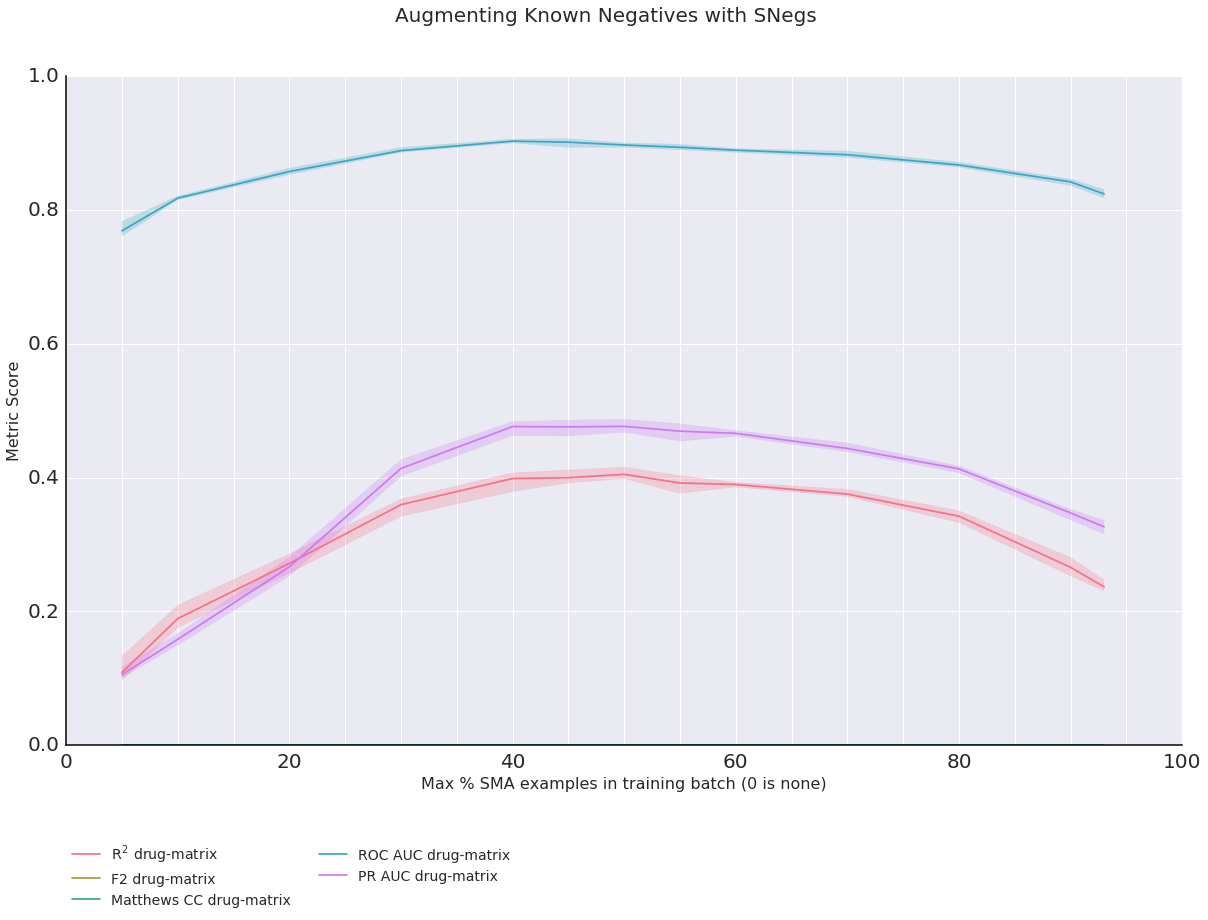

In [19]:
axes_size = 16
legend_size=14
legend_col = 2
title_size=20

metrics = ['binary-auc-t5.0-precision-recall_drug-matrix', 'binary-auc-t6.0-precision-recall_drug-matrix', 
           'binary-auc-t5.0-tpr-fpr_drug-matrix', 'binary-auc-t6.0-tpr-fpr_drug-matrix',
           'matthews-corrcoef_binary-5.0_drug-matrix', 'matthews-corrcoef_binary-6.0_drug-matrix', 
           'labeled-f2.0--Positive--_binary-5.0_drug-matrix', 
           'labeled-f2.0--Positive--_binary-6.0_drug-matrix', 
           'r2_drug-matrix-known-values',]# 'r2_timesplit-validation'] #, 'r2_train']

metrics = list(reversed([m for m in metrics if '5.0' not in m]))
metric_names = [m
                 .replace('-known-values','')
                 .replace('timesplit-validation','Time-Split')
                 .replace('test','Test-Set')
                 .replace('train','Train-Set')
                 .replace('drug-matrix-known-values', "Drug Matrix (Known Values)")

                 .replace('binary-auc-t6.0-tpr-fpr', 'ROC AUC')
                 .replace('binary-auc-t6.0-precision-recall', 'PR AUC')
                 .replace('matthews-corrcoef_binary-6.0','Matthews CC')
                 .replace('labeled-f2.0--Positive--_binary-6.0','F2')
                 .replace('_',' ')
                 .replace('r2','$\\regular{R^2}$')
                for m in metrics]

# sneg_type       
# no sea  = 1
# sea = 2

sns.set_style("whitegrid")
sns.set(font_scale=2)
# fig = plt.figure(figsize=(12,8))

fig, ax = plt.subplots(figsize=(20,12))

palette = sns.color_palette("husl", 5)
sns.set_palette(palette)

std_results_df = std_pnr_results_df[std_pnr_results_df['sneg_type'] != 2].copy()
plot_metrics_by_pnr(std_results_df, metrics, std_pnr_epochs, metric_names=metric_names, palette=palette,)

# palette = sns.color_palette("husl", 5)
# t_std_results_df = t_std_pnr_results_df[t_std_pnr_results_df['sneg_type'] != 2].copy()
# plot_metrics_by_pnr(t_std_results_df, metrics, test_std_pnr_epochs, metric_names=metric_names, palette=palette, linestyle='--', hatch='//')

# neg_results_df = neg_pnr_results_df[neg_pnr_results_df['sneg_type'] != 2].copy()
# plot_metrics_by_pnr(neg_results_df, metrics, neg_pnr_epochs, metric_names=metric_names, palette=palette, label_suffix=' (Only Stoch. Negs.)', linestyle='--', hatch='//')

plt.ylim(ymin=0.)


set_nice_spines(ax)

minorLocator = matplotlib.ticker.AutoMinorLocator()
ax.xaxis.set_minor_locator(minorLocator)

ax.xaxis.grid(True, which='minor') 

plt.suptitle('Augmenting Known Negatives with SNegs', size=title_size)
# plt.title('(0 is no stochastic negatives)', size=14)
plt.xlabel('Max % SMA examples in training batch (0 is none)', size=axes_size)
plt.ylabel('Metric Score', size=axes_size)
# plt.legend(loc='lower center')
plt.legend(bbox_to_anchor=(0, -0.25), loc=3, borderaxespad=0., fontsize=legend_size, ncol=legend_col)
plt.show()